In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

J = os.path.join

root = J(os.environ["DATASET_ROOT"], "bcd2022")

In [2]:
df = pd.read_csv(J(root,"train.csv"))
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
df.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

# Grouped analysis

In [19]:
dfg = df.groupby(['patient_id', 'laterality'])

In [20]:
# How many view per pid_laterality
dfg["view"].count().value_counts()

2    18384
3     4227
4      904
5      239
6       60
7       10
8        2
Name: view, dtype: int64

In [25]:
dfg["view"].apply(lambda x: sorted(list(x))).value_counts()[:10]

[CC, MLO]                      18384
[CC, MLO, MLO]                  2599
[CC, CC, MLO]                   1606
[CC, CC, MLO, MLO]               795
[CC, CC, MLO, MLO, MLO]          161
[CC, CC, CC, MLO, MLO]            71
[CC, MLO, MLO, MLO]               60
[CC, CC, CC, MLO, MLO, MLO]       46
[CC, CC, CC, MLO]                 44
[AT, CC, MLO]                     10
Name: view, dtype: int64

In [37]:
dfcount=dfg["view", "cancer", "biopsy"].agg({'view':'count', 
                                             'cancer':'mean', 
                                             'biopsy':'mean'})
print(dfcount["cancer"].value_counts())
print(dfcount.value_counts())

0.0    23334
1.0      492
Name: cancer, dtype: int64
view  cancer  biopsy
2     0.0     0.0       17578
3     0.0     0.0        3924
4     0.0     0.0         822
2     0.0     1.0         451
      1.0     1.0         355
5     0.0     0.0         220
3     0.0     1.0         196
      1.0     1.0         107
4     0.0     1.0          59
6     0.0     0.0          57
4     1.0     1.0          23
5     0.0     1.0          12
7     0.0     0.0           9
5     1.0     1.0           7
6     0.0     1.0           3
8     0.0     0.0           2
7     0.0     1.0           1
dtype: int64


/tmp/ipykernel_42640/1451783869.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfcount=dfg["view", "cancer", "biopsy"].agg({'view':'count',


# Correlations

In [59]:
from scipy.stats import chi2_contingency
 
def correlation(df, var_a, var_b):
    CrosstabResult=pd.crosstab(index=df[var_a],columns=df[var_b])
    # Performing Chi-sq test
    chi2, p, dof, expected = chi2_contingency(CrosstabResult)
    return CrosstabResult, expected, p

In [64]:
for var in ["site_id", "laterality", "view", "biopsy", "invasive", "BIRADS", "implant", "density", "machine_id", "difficult_negative_case"]:
    crosstable, expected, p = correlation(df, var, "cancer")
    if p<=0.05:
        print("+", var, "is correlated to cancer, p_value", p)
        print(crosstable)
        np.set_printoptions(suppress=True)
        print(expected)
    else:
        print("-", var, "is NOT correlated to cancer, p_value", p)

+ site_id is correlated to cancer, p_value 0.02126342159999086
cancer       0    1
site_id            
1        28855  664
2        24693  494
[[28894.15076957   624.84923043]
 [24653.84923043   533.15076957]]
- laterality is NOT correlated to cancer, p_value 0.539819693204795
- view is NOT correlated to cancer, p_value 0.22839468598585227
+ biopsy is correlated to cancer, p_value 0.0
cancer      0     1
biopsy             
0       51737     0
1        1811  1158
[[50641.84689065  1095.15310935]
 [ 2906.15310935    62.84689065]]
+ invasive is correlated to cancer, p_value 0.0
cancer        0    1
invasive            
0         53548  340
1             0  818
[[52747.31517567  1140.68482433]
 [  800.68482433    17.31517567]]
+ BIRADS is correlated to cancer, p_value 0.0
cancer      0    1
BIRADS            
0.0      7585  664
1.0     15772    0
2.0      2265    0
[[ 8040.6253519    208.3746481 ]
 [15373.58989576   398.41010424]
 [ 2207.78475234    57.21524766]]
+ implant is correlated t

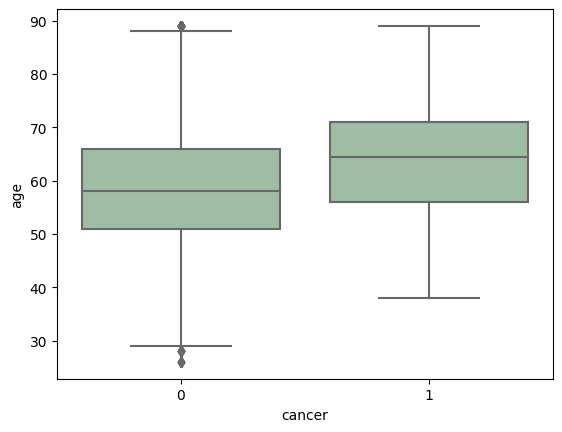

In [38]:
ax = sns.boxplot(x="cancer", y="age", data=df, color='#99c2a2')
plt.show()

In [200]:
dfg = df.groupby(["patient_id", "laterality"])["cancer"].count().reset_index()
new_df = pd.merge(df, dfg, on=["patient_id", "laterality"], ).rename(columns={"cancer_x": "cancer", "cancer_y": "count_pl"})
new_df["cancer"] = new_df["cancer"]/new_df["count_pl"]
new_df[new_df["cancer"]>0]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,count_pl
87,1,10130,388811999,L,MLO,71.0,0.25,1,1,0.0,0,B,49,False,4
88,1,10130,613462606,L,CC,71.0,0.25,1,1,0.0,0,B,49,False,4
89,1,10130,1360338805,L,CC,71.0,0.25,1,1,0.0,0,B,49,False,4
90,1,10130,1672636630,L,MLO,71.0,0.25,1,1,0.0,0,B,49,False,4
190,1,10226,461614796,L,MLO,71.0,0.50,1,1,0.0,0,C,49,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,0.50,1,1,NaN,0,NaN,21,False,2
54593,2,9840,111786935,R,MLO,59.0,0.50,1,1,NaN,0,NaN,21,False,2
54594,2,9840,1559360810,R,CC,59.0,0.50,1,1,NaN,0,NaN,21,False,2
54595,2,9851,1409270544,L,MLO,58.0,0.50,1,0,NaN,0,NaN,48,False,2


# 2. BIOPSY, DIFFICULT, BIRADS, CANCER, INVASIVE

In [178]:
df_s = df.copy()
df_s.loc[:, "BIRADS"] = df_s["BIRADS"].astype(str)
df_s.loc[:, "density"] = df_s["density"].astype(str)
df_s.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,nan,0,nan,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,nan,0,nan,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,nan,0,nan,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,nan,0,nan,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,nan,21,True


In [187]:
for c in [ "implant", "biopsy", "difficult_negative_case", "BIRADS", "invasive", "cancer", "density"]:
    df_g = df_s.groupby(["patient_id", "laterality"])
    df_g = df_g[c].apply(lambda x: (x.values[0]==x).all())
    r = df_g.sum()==len(df_g)
    if r == False:
        print(df_g.sum(), len(df_g), df_s[df_s["patient_id"].isin(df_g[df_g==False].index)])
    print(r,c)

True implant
True biopsy
True difficult_negative_case
True BIRADS
True invasive
True cancer
True density


## 2.1 difficult_negative_case

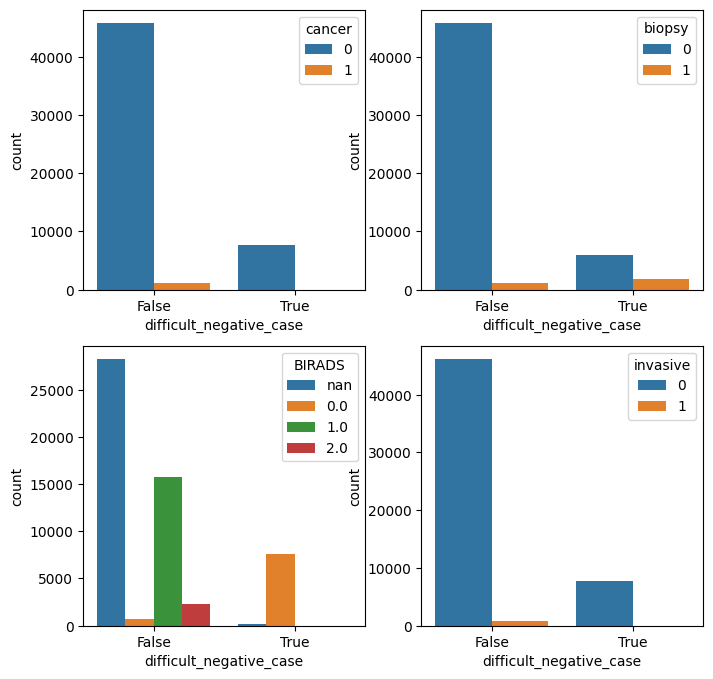

In [125]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
sns.countplot(data=df_s, x="difficult_negative_case", hue="cancer", ax=ax[0,0])
sns.countplot(data=df_s, x="difficult_negative_case", hue="biopsy", ax=ax[0,1])
sns.countplot(data=df_s, x="difficult_negative_case", hue="BIRADS", ax=ax[1,0])
sns.countplot(data=df_s, x="difficult_negative_case", hue="invasive", ax=ax[1,1])
plt.show()

- if **difficult_negative_case=1**  =>   **cancer=0**
- if **difficult_negative_case=1**  =>   **invasive=0**
- if **difficult_negative_case=1**  =>   **BIRADS=0.0 or NaN**

## 2.2 biopsy

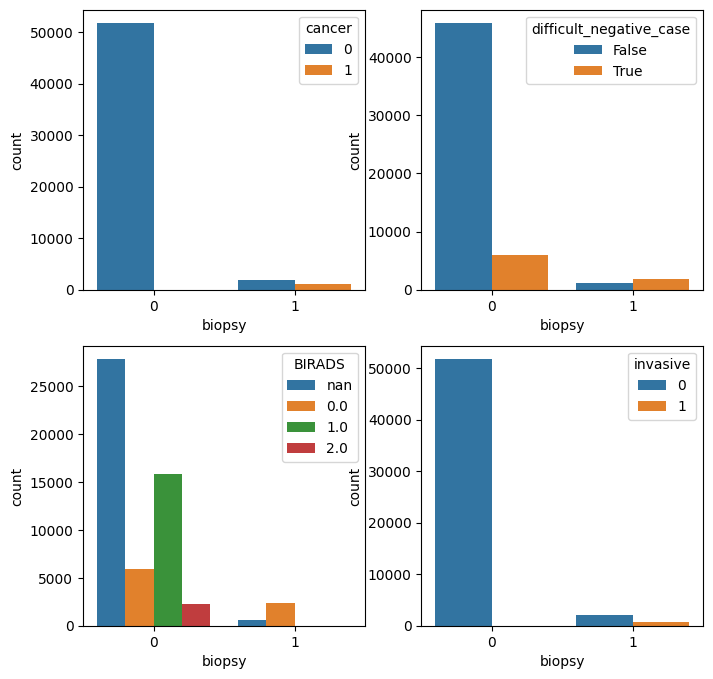

In [126]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
sns.countplot(data=df_s, x="biopsy", hue="cancer", ax=ax[0,0])
sns.countplot(data=df_s, x="biopsy", hue="difficult_negative_case", ax=ax[0,1])
sns.countplot(data=df_s, x="biopsy", hue="BIRADS", ax=ax[1,0])
sns.countplot(data=df_s, x="biopsy", hue="invasive", ax=ax[1,1])
plt.show()

- if **biopsy=0**  =>   **cancer=0**
- if **biopsy=0** => **invasive=0**
- if **biopsy=1** => **BIRADS=0.0 or nan**

## 2.3 BIRADS

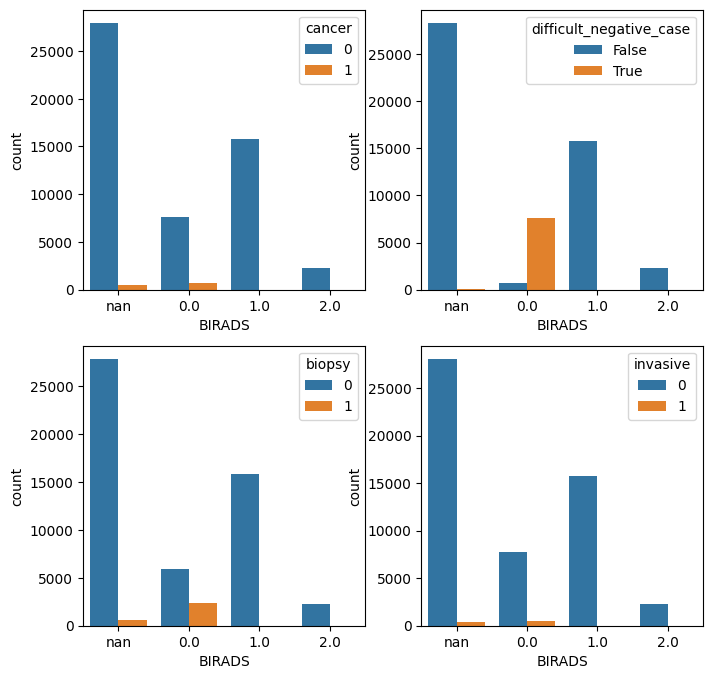

In [127]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
sns.countplot(data=df_s, x="BIRADS", hue="cancer", ax=ax[0,0])
sns.countplot(data=df_s, x="BIRADS", hue="difficult_negative_case", ax=ax[0,1])
sns.countplot(data=df_s, x="BIRADS", hue="biopsy", ax=ax[1,0])
sns.countplot(data=df_s, x="BIRADS", hue="invasive", ax=ax[1,1])
plt.show()

- if **BIRADS=1.0**  =>   **cancer=0**
- if **BIRADS=2.0**  =>   **cancer=0**
- if **BIRADS=1.0**  =>   **difficult_negative_case=0**
- if **BIRADS=2.0**  =>   **difficult_negative_case=0**
- if **BIRADS=1.0**  =>   **biopsy=0**
- if **BIRADS=2.0**  =>   **biopsy=0**
- if **BIRADS=1.0**  =>   **invasive=0**
- if **BIRADS=2.0**  =>   **invasive=0**

In [210]:
df_s.loc[(new_df["biopsy"]==1) & (new_df["cancer"]==0),"difficult_negative_case"].value_counts()

True    1811
Name: difficult_negative_case, dtype: int64

In [213]:
df_s.loc[(new_df["biopsy"]==0) & (new_df["difficult_negative_case"]==True), :]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,nan,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,nan,21,True
28,1,10049,94335194,R,MLO,52.0,0,0,0,0.0,0,C,49,True
29,1,10049,1207499426,R,MLO,52.0,0,0,0,0.0,0,C,49,True
30,1,10049,1351270472,R,CC,52.0,0,0,0,0.0,0,C,49,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54672,2,9953,1640274067,R,MLO,60.0,0,0,0,0.0,0,nan,48,True
54673,2,9954,21064441,L,MLO,48.0,0,0,0,0.0,0,nan,48,True
54674,2,9954,2043422318,L,CC,48.0,0,0,0,0.0,0,nan,48,True
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


## 2.4 invasive

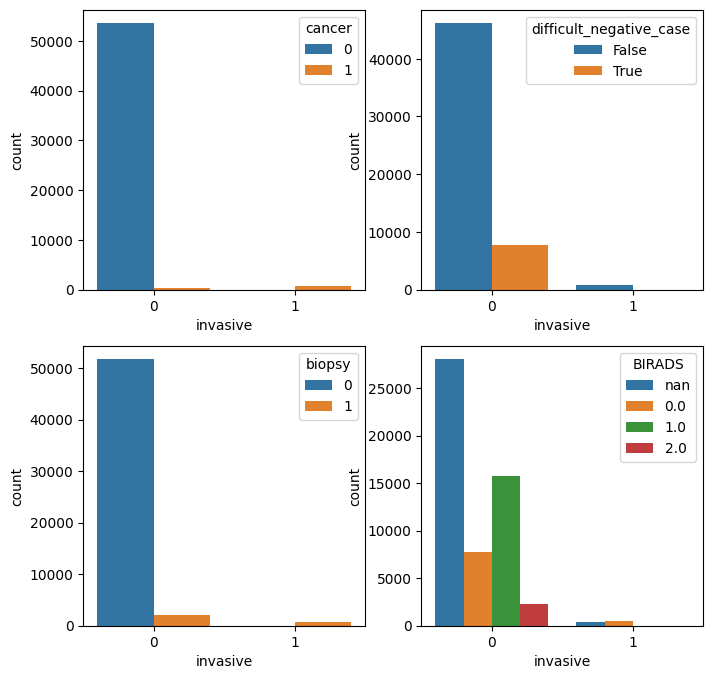

In [129]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
sns.countplot(data=df_s, x="invasive", hue="cancer", ax=ax[0,0])
sns.countplot(data=df_s, x="invasive", hue="difficult_negative_case", ax=ax[0,1])
sns.countplot(data=df_s, x="invasive", hue="biopsy", ax=ax[1,0])
sns.countplot(data=df_s, x="invasive", hue="BIRADS", ax=ax[1,1])
plt.show()

- if **invasive=1**  =>  **cancer=1**
- if **invasive=1**  =>  **difficult_negative_case=0**
- if **invasive=1**  =>  **biopsy=1**
- if **invasive=1**  =>  **BIRADS=0.0 or NaN**

## 3.5 cancer

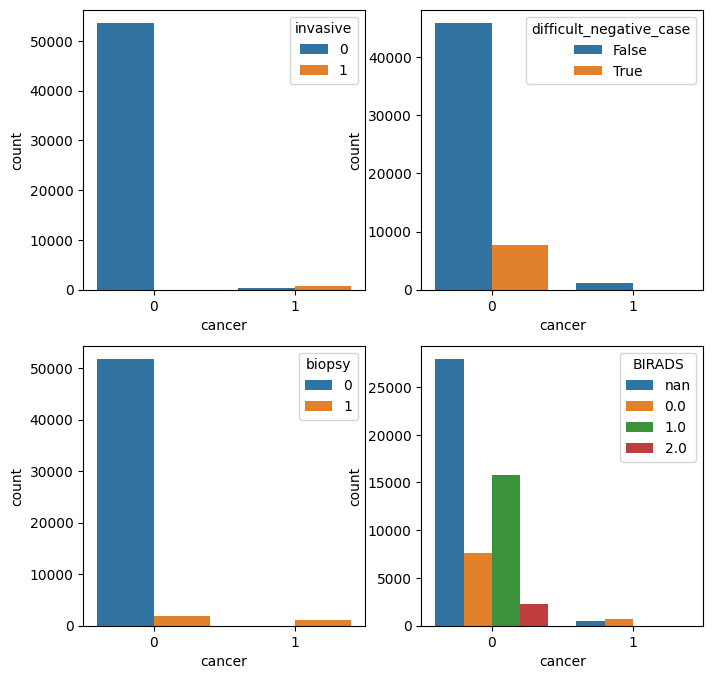

In [133]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
sns.countplot(data=df_s, x="cancer", hue="invasive", ax=ax[0,0])
sns.countplot(data=df_s, x="cancer", hue="difficult_negative_case", ax=ax[0,1])
sns.countplot(data=df_s, x="cancer", hue="biopsy", ax=ax[1,0])
sns.countplot(data=df_s, x="cancer", hue="BIRADS", ax=ax[1,1])
plt.show()

- if **cancer=o**  =>  **invasive=0**
- if **cancer=1**  =>  **difficult_negative_case=0**
- if **cancer=1**  =>  **biopsy=1**
- if **cancer=1**  =>  **BIRADS=0.0 or NaN**

## 3.6 Results

- if **difficult_negative_case=1**  =>   **cancer=0**
- if **difficult_negative_case=1**  =>   **invasive=0**
- if **difficult_negative_case=1**  =>   **BIRADS=0.0 or NaN**
- if **biopsy=0**  =>   **cancer=0**
- if **biopsy=0** => **invasive=0**
- if **biopsy=1** => **BIRADS=0.0 or nan**
- if **BIRADS=1.0**  =>   **cancer=0**
- if **BIRADS=2.0**  =>   **cancer=0**
- if **BIRADS=1.0**  =>   **difficult_negative_case=0**
- if **BIRADS=2.0**  =>   **difficult_negative_case=0**
- if **BIRADS=1.0**  =>   **biopsy=0**
- if **BIRADS=2.0**  =>   **biopsy=0**
- if **BIRADS=1.0**  =>   **invasive=0**
- if **BIRADS=2.0**  =>   **invasive=0**
- if **invasive=1**  =>  **cancer=1**
- if **invasive=1**  =>  **difficult_negative_case=0**
- if **invasive=1**  =>  **biopsy=1**
- if **invasive=1**  =>  **BIRADS=0.0 or NaN**
- if **cancer=o**  =>  **invasive=0**
- if **cancer=1**  =>  **difficult_negative_case=0**
- if **cancer=1**  =>  **biopsy=1**
- if **cancer=1**  =>  **BIRADS=0.0 or NaN**

In [7]:
df["density"].fillna(df["density"].value_count().max().index)

array([nan, 'C', 'D', 'B', 'A'], dtype=object)

In [4]:
df_pos = df[df["cancer"]==1]

In [13]:
files = df_pos["patient_id"].astype(str)+"_"+df_pos["image_id"].astype(str)+".png"
for f in files:
    plt.imshow(plt.open(J(root, f)))

In [3]:
df.groupby("patient_id")["cancer"].apply(lambda x: x.sum()>0).astype(int)

patient_id
5        0
25       0
28       0
30       0
33       0
        ..
65518    0
65525    0
65526    0
65530    0
65534    0
Name: cancer, Length: 11913, dtype: int64

In [3]:
p1 = df[df.cancer==1]["patient_id"]
p2 = df[df.cancer==0]["patient_id"]

In [4]:
print(len(p1), len(p2), len(set(p1.values).intersection(set(p2.values))))

1158 53548 480


In [5]:
df[df["difficult_negative_case"]==True]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
28,1,10049,94335194,R,MLO,52.0,0,0,0,0.0,0,C,49,True
29,1,10049,1207499426,R,MLO,52.0,0,0,0,0.0,0,C,49,True
30,1,10049,1351270472,R,CC,52.0,0,0,0,0.0,0,C,49,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54672,2,9953,1640274067,R,MLO,60.0,0,0,0,0.0,0,NaN,48,True
54673,2,9954,21064441,L,MLO,48.0,0,0,0,0.0,0,NaN,48,True
54674,2,9954,2043422318,L,CC,48.0,0,0,0,0.0,0,NaN,48,True
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [6]:
df[df["patient_id"]==5]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
37282,2,5,640805896,L,MLO,68.0,0,0,0,0.0,0,NaN,21,True
37283,2,5,1351088028,L,CC,68.0,0,0,0,0.0,0,NaN,21,True
37284,2,5,940388076,R,CC,68.0,0,0,0,NaN,0,NaN,21,False
37285,2,5,1633417959,R,MLO,68.0,0,0,0,NaN,0,NaN,21,False


<AxesSubplot: xlabel='image_id', ylabel='Count'>

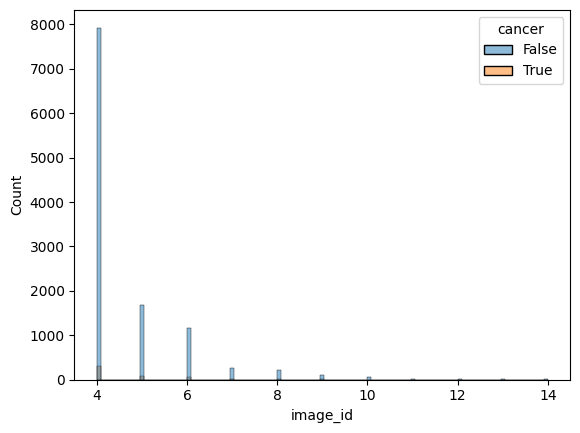

In [15]:
leak = pd.concat([df.groupby("patient_id")["image_id"].count(), df.groupby("patient_id")["cancer"].any()], axis=1)
sns.histplot(leak, x="image_id", hue="cancer")

In [22]:
for nc in range(5, 15):
    lsel = leak[leak.image_id==nc]
    print(nc, len(lsel[lsel.cancer])/len(lsel))

5 0.05036785512167515
6 0.04926108374384237
7 0.06521739130434782
8 0.034934497816593885
9 0.0707070707070707
10 0.018867924528301886
11 0.0
12 0.0
13 0.0
14 0.0


In [84]:
df_prob = pd.concat([df.groupby("patient_id")["image_id"].count(),
                     df.groupby("patient_id")["cancer"].sum(),
                     df.groupby("patient_id")["cancer"].any()], keys=["image_id", "pos_cancer", "cancer"], axis=1)
df_prob["p"] = 0
df_prob.loc[df_prob["cancer"]==1, "p"] = df_prob[df_prob["cancer"]==1]["pos_cancer"]/df_prob[df_prob["cancer"]==1]["image_id"]
df_prob[df_prob["cancer"]==1]["p"]

patient_id
106      0.5
236      0.4
283      0.5
500      0.5
729      0.5
        ... 
65222    0.6
65224    0.4
65244    0.4
65427    0.5
65492    0.5
Name: p, Length: 486, dtype: float64

# Check cancer distribution

In [18]:
def countplot(x, hue="cancer"):
    df_new = df.copy()
    df_new[x].fillna("nan", inplace=True)
    df_new[hue].fillna("nan", inplace=True)
    ax=sns.countplot(df_new, x=x, hue=hue)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=10)

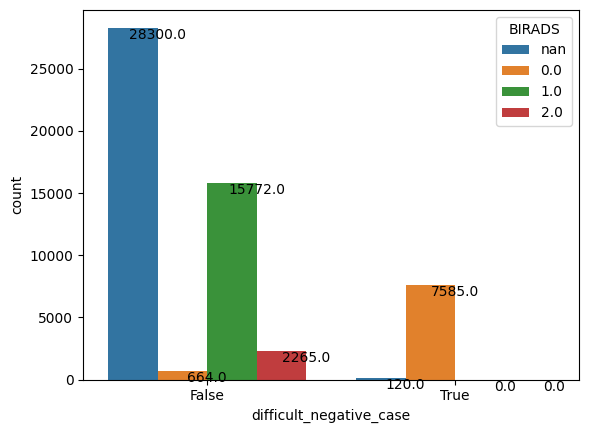

In [21]:
countplot("difficult_negative_case", "BIRADS")

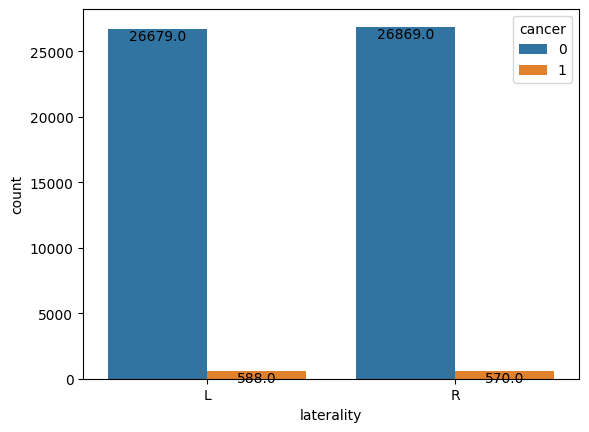

In [5]:
countplot("laterality")

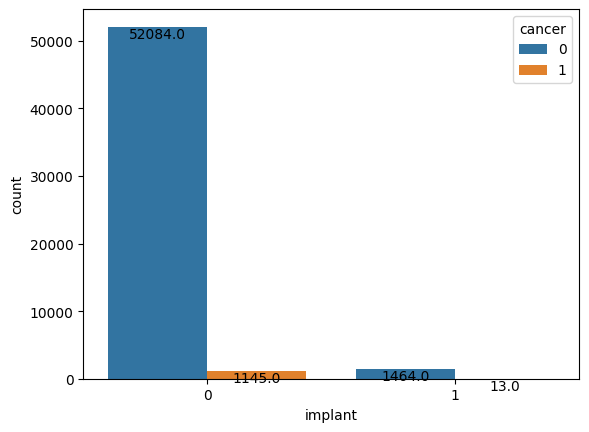

In [6]:
countplot("implant")

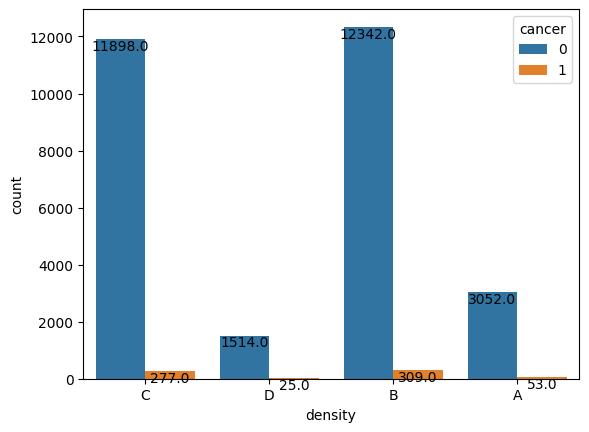

In [62]:
countplot("density")

In [11]:
df["pred"] = np.random.rand(len(df))
df["pid"] = df["patient_id"].astype(str) + "_" + df["laterality"]
df_g1 = df.groupby("pid")["pred"].sum()
df_g = df.groupby("pid")["pred"].apply(lambda x: (x >= 0.5).sum() >= len(x)*0.5).astype(int)
df_g1

pid
10006_L    1.552893
10006_R    1.558744
10011_L    0.774033
10011_R    1.231390
10025_L    1.051731
             ...   
9973_R     1.205189
997_L      0.264304
997_R      1.083062
9989_L     0.605536
9989_R     0.451664
Name: pred, Length: 23826, dtype: float64

: 

In [8]:
df_g

pid
10006_L    0
10006_R    0
10011_L    1
10011_R    0
10025_L    0
          ..
9973_R     0
997_L      1
997_R      1
9989_L     0
9989_R     0
Name: pred, Length: 23826, dtype: int64